In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to dataset
train_dir = '/Users/giripragada/Downloads/chest_xray/train'
test_dir = '/Users/giripragada/Downloads/chest_xray/test'
val_dir = '/Users/giripragada/Downloads/chest_xray/val'




In [3]:
# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Function to load and preprocess images
def load_and_preprocess_images(data_dir, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    data = []
    labels = []
    
    # Loop through the subdirectories (i.e., classes) in the data directory
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            label = 0 if label_dir == 'NORMAL' else 1  # Label 0 for Normal, 1 for Pneumonia
            
            # Loop through each image in the current label directory
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path)
                
                if img is not None:
                    # Resize image to uniform size
                    img_resized = cv2.resize(img, target_size)
                    data.append(img_resized)
                    labels.append(label)

    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels


Training data shape: (5216, 224, 224, 3)
Testing data shape: (624, 224, 224, 3)
Validation data shape: (16, 224, 224, 3)


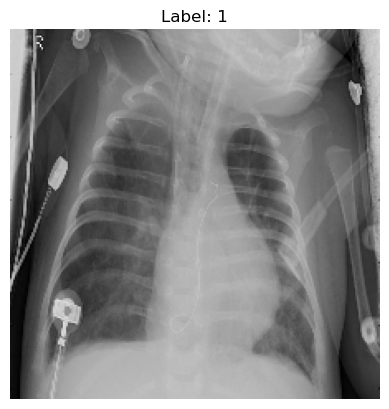

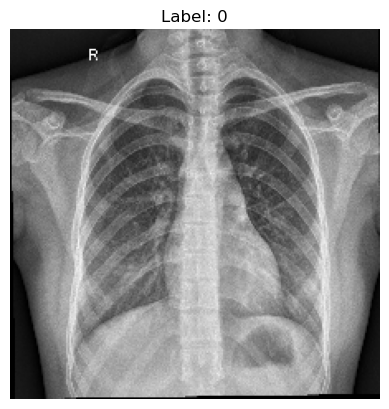

In [5]:
# Load training, testing, and validation data
train_data, train_labels = load_and_preprocess_images(train_dir)
test_data, test_labels = load_and_preprocess_images(test_dir)
val_data, val_labels = load_and_preprocess_images(val_dir)

# Normalize pixel values to range [0, 1]
train_data = train_data / 255.0
test_data = test_data / 255.0
val_data = val_data / 255.0

# Check the shapes of the loaded datasets
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

import matplotlib.pyplot as plt

# Assuming train_data and train_labels are numpy arrays or similar structures
# Let's assume the labels are binary, e.g., 0 and 1
class_labels = [0, 1]  # Change if necessary
class_sample_indices = {}  # To store one sample index per class

# Find one image per class
for idx, label in enumerate(train_labels):
    if label in class_labels and label not in class_sample_indices:
        class_sample_indices[label] = idx
    if len(class_sample_indices) == len(class_labels):  # Stop when both classes are found
        break

# Plot one image per class
for class_label, sample_idx in class_sample_indices.items():
    plt.imshow(train_data[sample_idx])  # Assuming train_data is a 2D or 3D array per sample
    plt.title(f"Label: {class_label}")
    plt.axis('off')  # Hide axes for cleaner visualization
    plt.show()


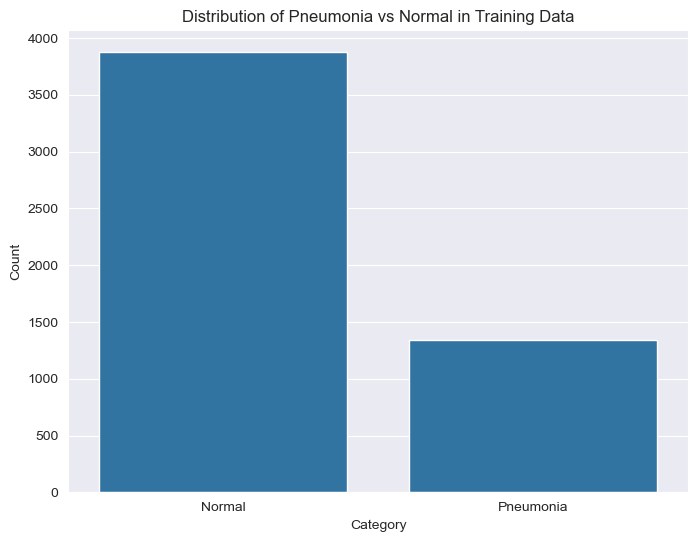

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


# Map labels to string categories
label_map = {0: 'Pneumonia', 1: 'Normal'}

# Map train_labels to their respective category names
label_names = [label_map[label] for label in train_labels]

# Plot the distribution using seaborn countplot
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
sns.countplot(x=label_names)
plt.title("Distribution of Pneumonia vs Normal in Training Data")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()
        

In [ ]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Reshape data for deep learning
train_data = train_data.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)  # 3 for RGB channels
test_data = test_data.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
val_data = val_data.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        
)

datagen.fit(train_data)




In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# 
model = Sequential()

# First Convolutional Block
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))

# Third Convolutional Block 
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))  # Smaller dense layer
model.add(Dropout(0.4))  # Moderate dropout rate

# Output Layer for Binary Classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer for efficient convergence
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to check the architecture
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,605,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,729 (6.22 MB)

 Trainable params: 1,629,505 (6.22 MB)

 Non-trainable params: 224 (896.00 B)

In [13]:
# Learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.3, min_lr=0.000001)

# Training the model
history = model.fit(datagen.flow(train_data, train_labels, batch_size=BATCH_SIZE),
                    epochs=12,
                    validation_data=(val_data, val_labels),
                    callbacks=[learning_rate_reduction])

# Model evaluation
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Loss of the model is: {loss}")
print(f"Accuracy of the model is: {accuracy * 100}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 392ms/step - accuracy: 0.7359 - loss: 1.7729 - val_accuracy: 0.5000 - val_loss: 29.2802 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 402ms/step - accuracy: 0.8592 - loss: 0.4360 - val_accuracy: 0.5000 - val_loss: 21.2826 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 517ms/step - accuracy: 0.8966 - loss: 0.3945 - val_accuracy: 0.5000 - val_loss: 14.6988 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 567ms/step - accuracy: 0.9203 - loss: 0.3655 - val_accuracy: 0.5000 - val_loss: 9.0371 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 569ms/step - accuracy: 0.9190 - loss: 0.3251 - val_accuracy: 0.5000 - val_loss: 6.9512 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 544ms/step - accuracy: 0.9143 - loss: 0.3213 - val_accuracy: 0.6250 - val_loss: 4.7894 - learning_rate: 9.0000e-05
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 463ms/step 

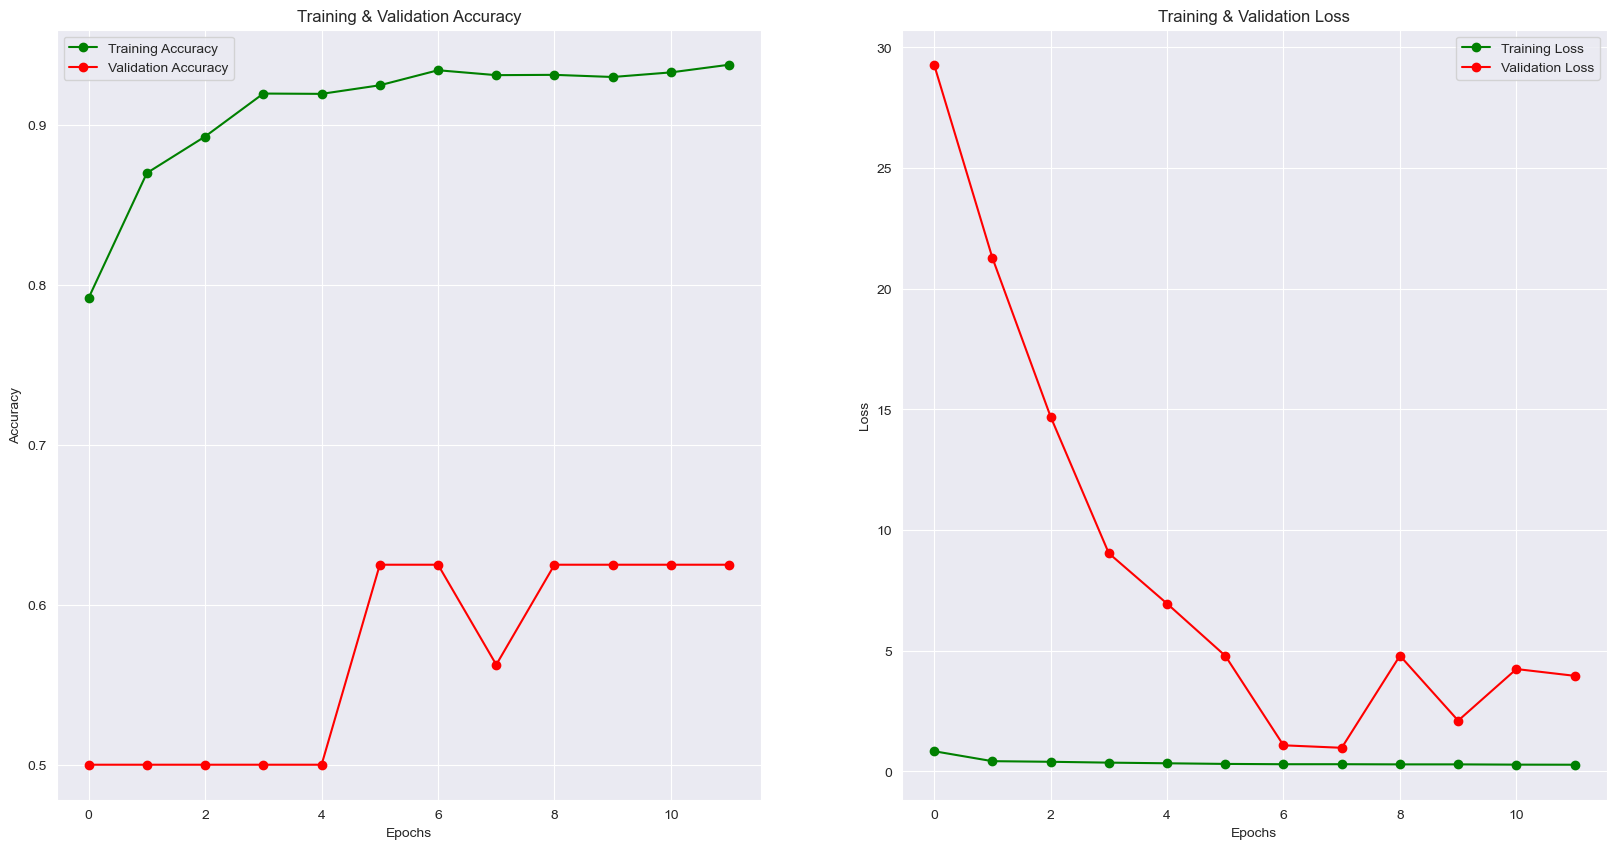

In [15]:
# Plotting training and validation accuracy & loss
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()


In [17]:

# Predictions and classification report
predictions = model.predict(test_data)
predictions = (predictions > 0.5).astype(int)  # Converting probabilities to binary labels

print(classification_report(test_labels, predictions, target_names=['Normal', 'Pneumonia']))


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
              precision    recall  f1-score   support

      Normal       0.89      0.56      0.69       234
   Pneumonia       0.79      0.96      0.86       390

    accuracy                           0.81       624
   macro avg       0.84      0.76      0.78       624
weighted avg       0.82      0.81      0.80       624



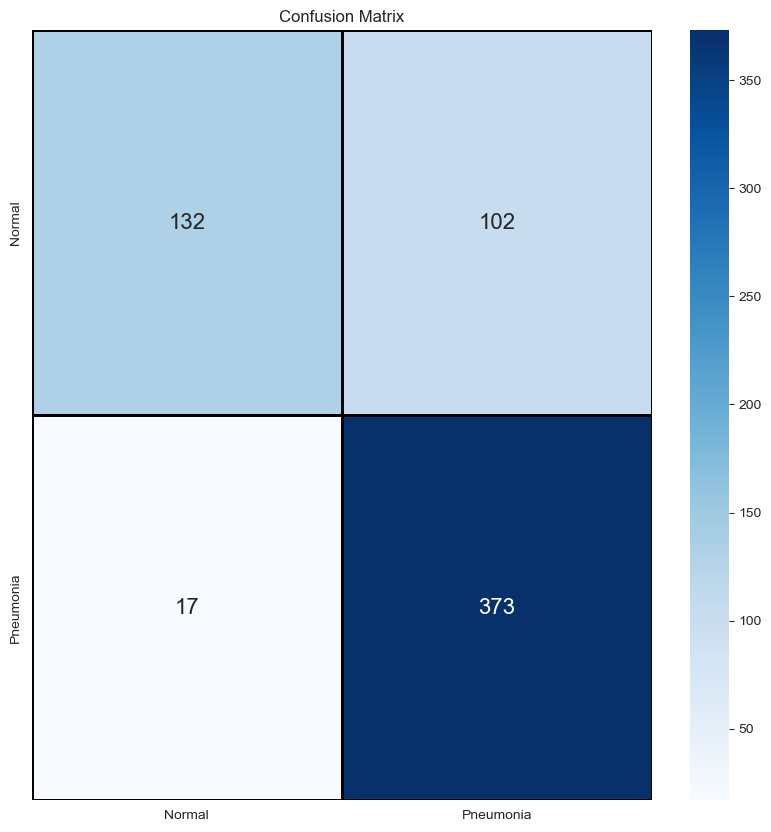

In [19]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index=['Normal', 'Pneumonia'], columns=['Normal', 'Pneumonia'])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Visualize correct predictions
correct = np.nonzero(predictions.flatten() == test_labels)[0]
incorrect = np.nonzero(predictions.flatten() != test_labels)[0]


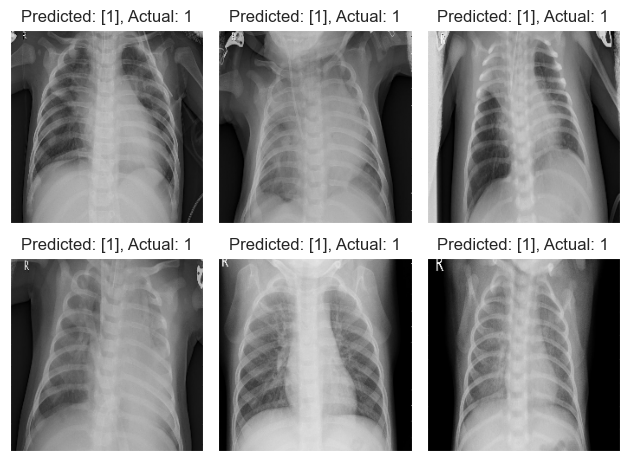

In [23]:
# Show 6 correct predictions
i = 0
for c in correct[:6]:
    plt.subplot(2, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[c], cmap="gray")
    plt.title(f"Predicted: {predictions[c]}, Actual: {test_labels[c]}")
    plt.tight_layout()
    i += 1



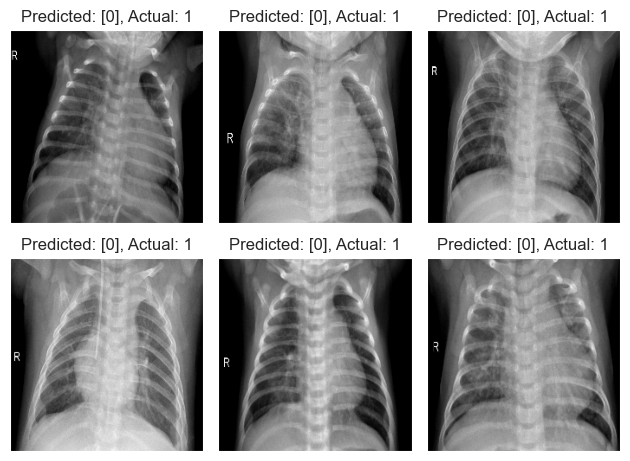

In [25]:
# Show 6 incorrect predictions
i = 0
for c in incorrect[:6]:
    plt.subplot(2, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[c], cmap="gray")
    plt.title(f"Predicted: {predictions[c]}, Actual: {test_labels[c]}")
    plt.tight_layout()
    i += 1

plt.show()